In [2]:
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install pandas
!python -m pip install requests
!python -m pip install codecs
!python -m pip install tabulate
!python -m pip install csv
!python -m pip install plotly

ERROR: Could not find a version that satisfies the requirement codecs (from versions: none)
ERROR: No matching distribution found for codecs


ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import requests
import codecs
import csv

from IPython.display import Image
from contextlib import closing
from tabulate import tabulate


%matplotlib inline

In [2]:
def create_url_query(element_id, data_type, pressure, T_high, T_low, T_inc):
    base = 'https://webbook.nist.gov/cgi/fluid.cgi?'
    action = 'Action=Data&Wide=on&'
    element = 'ID={}&'.format(element_id)
    return_type = 'Type={}&'.format(data_type)
    digits = 'digits=5&'
    P = 'P={}&'.format(pressure)
    THigh = 'THigh={}&'.format(T_high)
    TLow = 'TLow={}&'.format(T_low)
    TInc='TInc={}&'.format(T_inc)
    units = 'RefState=DEF&TUnit=K&PUnit=psia&DUnit=kg%2Fm3&HUnit=kJ%2Fkg&WUnit=m%2Fs&VisUnit=Pa*s&STUnit=N%2Fm'
    
    url = '{base}{action}{element}{return_type}{digits}{P}{THigh}{TLow}{TInc}{units}'.format(base=base,
                                                                                            action=action,
                                                                                            element=element,
                                                                                            return_type=return_type,
                                                                                            digits=digits,
                                                                                            P=P,
                                                                                            THigh=THigh,
                                                                                            TLow=TLow,
                                                                                            TInc=TInc,
                                                                                            units=units)
    return url

In [3]:
nitrogen_id = 'C7727379'
helium_id = 'C7440597'

url = create_url_query(helium_id, 'IsoBar', 14.7, 305.0, 77.0, 1.0)

In [4]:
df = pd.read_csv(url, delimiter='\t')
df.head()

,Temperature (K),Pressure (psia),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Enthalpy (kJ/kg),Entropy (J/g*K),Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (F/psia),Viscosity (Pa*s),Therm. Cond. (W/m*K),Phase
0,77.0,14.7,0.63249,1.5811,245.08,405.32,20.935,3.1171,5.1958,517.30,-0.005772,0.000008,0.061930,vapor
1,78.0,14.7,0.62439,1.6016,248.19,410.52,21.002,3.1171,5.1957,520.64,-0.005834,0.000008,0.062462,vapor
2,79.0,14.7,0.61650,1.6221,251.31,415.71,21.069,3.1171,5.1956,523.95,-0.005895,0.000008,0.062991,vapor
3,80.0,14.7,0.60880,1.6426,254.43,420.91,21.134,3.1171,5.1955,527.25,-0.005953,0.000009,0.063519,vapor
4,81.0,14.7,0.60130,1.6631,257.55,426.10,21.199,3.1170,5.1954,530.52,-0.006009,0.000009,0.064045,vapor


## Grashof - Rayleigh Equations:

Grashoff number: A dimensionless number which approximates the ratio of the buoyancy to viscous force acting on a fluid.

Rayleigh number:  A dimensionless number associated with buoyancy-driven flow, also known as free or natural convection. It characterises the fluid's flow regime. The magnitude is a good indication as to whether the natural convection boundary layer is laminar or turbulent. 

In [5]:
rayleigh_number = lambda G_r, P_r: G_r*P_r   
nusselt_number_turbulence = lambda Re_D, Pr, n: 0.023*math.pow(Re_D, 0.8)*math.pow(Pr, n) 
laminar_check = lambda i: i < 10e9
characteristic_length_disk = lambda r1, r2: (math.pi*(math.pow(max(r1,r2), 2) - math.pow(min(r1,r2), 2)))/(2*math.pi*max(r1,r2))  
characteristic_length_plate = lambda w, l: (w*l)/(2*(w + l)) 
pascal_to_psi = lambda p: (1/6894.76)*p
psi_to_pascal = lambda p: 6894.76*p

## Nusselt Number Equations: 
Nusselt number: Provides information about the ration of the convective heat transfer to conductive heat transfer in a fluid.

In [6]:
def grashof_number(g, beta, T_1, T_2, L, nu):
    return g*beta*(max(T_1, T_2) - min(T_1, T_2))*math.pow(L, 3)/(math.pow(nu, 2))

def nusselt_number_long_cylinder(Ra_D, Pr):
    return math.pow(0.6 + (0.387*math.pow(Ra_D, 1/6))/math.pow( 1 + math.pow(0.559/P_r, 9/16), 8/27), 2)

def nusselt_number_vertical_plates(Ra_L, P_r):
    if Ra_L < 10e9:
        return 0.68 + (0.67*math.pow(Ra_L, 1/4))/math.pow( 1 + math.pow(0.492/P_r, 9/16), 4/9)
    else:
        return math.pow(0.825 + (0.387*math.pow(Ra_L, 1/6))/math.pow( 1 + math.pow(0.492/P_r, 9/16), 8/27), 2)

def check_D_L_condition(D, L, Gr_L):
    if D/L > 35/math.pow(Gr_L, 0.25):
        return True
    else:
        return False

def check_convection_type(Ge, Re):
    return Ge/math.pow(Re, 2)
    
def reynolds_number(W, mu, D):
    return 4*W/(math.pi*mu*D)
    
def nusselt_number_lower_cold(Ra):
    if Ra > 8e4 and Ra < 10e7:
        return 0.54*math.pow(Ra, 1/4)
    elif Ra > 10e7 and Ra < 10e11:
        return 0.15*math.pow(Ra, 1/3)
    else:
        return 0
    
def nusselt_number_upper_cold(Ra_L):
    if Ra_L > 8e4 and Ra_L < 10e10:
        return 0.27*math.pow(Ra_L, 1/4)
    else:
        return 0

def compute_heat_transfer_coefficient(Nu, k, L):
    return Nu*k/L

def computer_radiative_heat_transfer(T, T_inf, eps,surface_area):
    stephan_boltzmann = 5.67373e-8      # W/m^2 K^4
    q_radiative = eps*surface_area*stephan_boltzmann*(math.pow(T_inf, 4) - math.pow(T, 4))
    
    return q_radiative
    

def volumetric_expansion_coefficient(rho, rho_inf, T, T_inf):
    return (1/rho)*(rho_inf - rho)/(T - T_inf)

def get_horizontal_plate_coefficient_upper(Ra):
    if Ra > 10e4 and Ra < 10e7:
        return 0.54
    elif Ra > 10e7 and Ra < 10e11:
        return 0.15
    else:
        return 0
    
def get_horizontal_plate_coefficient_lower(Ra):
    if Ra > 8e4 and Ra < 10e10:
        return 0.27
    else:
        return 0   
    

## Nitrogen vessel geometry constants (m)

![title](cross_section.png)

In [7]:
inner_top_plate_radius = 0.44          # Diagram C
inner_bottom_plate_radius = 0.37       # Diagram B
top_plate_thickness = 0.023            # Diagram C - Thickness
outer_wall_thickness =  0.0051         # Diagram E - Thickness
inner_wall_thickness =  0.0051         # Diagram A - Thickness
inner_length = 0.48                    # Diagram A - Length
outer_length = 0.61                    # Diagram E - Length
inner_channel_length = 0.15            # Diagram D - Length
inner_channel_radius = 0.12            # Diagram D - Radius
inner_channel_thickness = 0.003        # Diagram D - Thickness
nitrogen_port_inner_diameter = 0.01    # Diagram F - 0.375" ID
nitrogen_port_outer_diameter = 0.013   # Diagram F - 0.520" OD
nitrogen_port_length = 0.197           # Diagram F - Length
nitrogen_lower_plate_thickness = 0.005

## Thermal properties of liquids - He @ 300K

In [8]:
nu = 122e-6                          # m^2/s
k = 152e-3                           # W/m*K 
alpha = 180e-6                       # m^2/s
mu = 199e-7                          # N*s/m^2
Pr = 0.680                           # Prandl number
T = 78                               # Approximate temperature inner surfaces before vacuum loss(K)
T_inf = 300                          # Approximate temperature atmosphere(K)
g = 9.8
sigma = 5.6703e-8                    # Stephan-Boltzmann ( W/(m^2 K^4) ) 
epsilon = 1                          # Need the value(s) for the pipe(s)
stephan_boltzmann = 5.67373e-8       # W/m^2 K^4
nitrogen_mass = 28.014               # diatomic mass nitrogen

rho = df[df['Temperature (K)'] == 78]['Density (kg/m3)'].iloc[0]
rho_inf = df[df['Temperature (K)'] == 300]['Density (kg/m3)'].iloc[0]
beta = volumetric_expansion_coefficient(rho, rho_inf, T, T_inf) # K^-1

## Classification of flow regime
The first step if to calculate the rayleigh number which will classify the convective flow regime and dicate which correlation equations we use in the heat transfer coefficient calculations.

In [40]:
# Vertical plates
L_o = characteristic_length_plate(2*math.pi*inner_top_plate_radius, outer_length)
L_i = characteristic_length_plate(2*math.pi*inner_bottom_plate_radius, inner_length)
L_c = characteristic_length_plate(2*math.pi*inner_channel_radius, inner_channel_length)

Gr_outer_length = grashof_number(g, beta, T, T_inf, L_o, nu)
Ra_outer_length = rayleigh_number(Gr_outer_length, Pr)

Gr_inner_length = grashof_number(g, beta, T, T_inf, L_i, nu)
Ra_inner_length = rayleigh_number(Gr_inner_length, Pr)

Gr_inner_channel_length = grashof_number(g, beta, T, T_inf, L_c, nu)
Ra_inner_channel_length = rayleigh_number(Gr_inner_channel_length, Pr)

# Horizontal plates

L_t = characteristic_length_disk(inner_top_plate_radius, inner_channel_radius)
Gr_inner_top_plate = grashof_number(g, beta, T, T_inf, L_t, nu)
Ra_inner_top_plate = rayleigh_number(Gr_inner_top_plate, Pr)

L_b = characteristic_length_disk(inner_bottom_plate_radius, inner_channel_radius)
Gr_inner_bottom_plate = grashof_number(g, beta, T, T_inf, L_b, nu)
Ra_inner_bottom_plate = rayleigh_number(Gr_inner_bottom_plate, Pr)

L_l = characteristic_length_disk(inner_top_plate_radius, inner_bottom_plate_radius)
Gr_lower_bottom_plate = grashof_number(g, beta, T, T_inf, L_l, nu)
Ra_lower_bottom_plate = rayleigh_number(Gr_lower_bottom_plate, Pr)

table = [["Outer vessel surface", laminar_check(Gr_outer_length), 
            Gr_outer_length/math.pow(Ra_outer_length,2), L_o, Gr_outer_length],
        ["Inner vessel surface", laminar_check(Gr_inner_length),
         Gr_inner_length/math.pow(Ra_inner_length,2), L_i, Gr_inner_length],
        ["Inner channel surface", laminar_check(Gr_inner_channel_length), 
         Gr_inner_channel_length/math.pow(Ra_inner_channel_length,2), L_c, Gr_inner_channel_length],
        ["Inner top plate surface", laminar_check(Gr_inner_top_plate),
         Gr_inner_top_plate/math.pow(Ra_inner_top_plate,2), L_t, Gr_inner_top_plate],
        ["Inner bottom plate surface", laminar_check(Gr_inner_bottom_plate),
         Gr_inner_bottom_plate/math.pow(Ra_inner_bottom_plate,2), L_b, Gr_inner_bottom_plate],
        ["Lower bottom plate surface", laminar_check(Gr_lower_bottom_plate),
         Gr_lower_bottom_plate/math.pow(Ra_lower_bottom_plate,2), L_l, Gr_lower_bottom_plate]]

headers = ["Plate Name", "Laminar(True|False)", "Free/Forced Ratio", "Char. Length", "Grashof number"]

print(tabulate(table, headers, tablefmt="psql"))

0.0033316841561688536
+----------------------------+-----------------------+---------------------+----------------+------------------+
| Plate Name                 |   Laminar(True|False) |   Free/Forced Ratio |   Char. Length |   Grashof number |
|----------------------------+-----------------------+---------------------+----------------+------------------|
| Outer vessel surface       |                     1 |         2.84662e-07 |      0.249868  |      7.59719e+06 |
| Inner vessel surface       |                     1 |         5.64126e-07 |      0.198927  |      3.83359e+06 |
| Inner channel surface      |                     1 |         1.81414e-05 |      0.0625551 | 119209           |
| Inner top plate surface    |                     1 |         5.25888e-07 |      0.203636  |      4.11234e+06 |
| Inner bottom plate surface |                     1 |         9.78917e-07 |      0.165541  |      2.20921e+06 |
| Lower bottom plate surface |                     1 |         1.66019e-05

## Calculation of Nusselt Number

In [10]:
# Vertical plates

Nu_outer_length = nusselt_number_vertical_plates(Ra_outer_length, Pr)
Nu_inner_length = nusselt_number_vertical_plates(Ra_inner_length, Pr)
Nu_channel_length = nusselt_number_vertical_plates(Ra_inner_channel_length, Pr)

# Horizontal plates

Nu_inner_top = nusselt_number_upper_cold(Ra_inner_top_plate)
Nu_inner_bottom = nusselt_number_lower_cold(Ra_inner_bottom_plate)
Nu_lower_bottom = nusselt_number_lower_cold(Ra_lower_bottom_plate)

table = [["Outer vessel surface", "NA", Nu_outer_length],
        ["Inner vessel surface", "NA", Nu_inner_length],
        ["Inner channel surface", "NA", Nu_channel_length],
        ["Inner top plate surface", get_horizontal_plate_coefficient_upper(Ra_inner_top_plate), Nu_inner_top],
        ["Inner bottom plate surface", get_horizontal_plate_coefficient_lower(Ra_inner_bottom_plate), Nu_inner_bottom],
        ["Lower bottom plate surface", get_horizontal_plate_coefficient_lower(Ra_lower_bottom_plate), Nu_lower_bottom]]

headers = ["Plate Name", "Horizontal plate coefficient", "Nusselt number"]
print(tabulate(table, headers, tablefmt="psql"))

+----------------------------+--------------------------------+------------------+
| Plate Name                 | Horizontal plate coefficient   |   Nusselt number |
|----------------------------+--------------------------------+------------------|
| Outer vessel surface       | NA                             |         25.0774  |
| Inner vessel surface       | NA                             |         21.2428  |
| Inner channel surface      | NA                             |          9.31492 |
| Inner top plate surface    | 0.54                           |         11.0411  |
| Inner bottom plate surface | 0.27                           |         18.9051  |
| Lower bottom plate surface | 0.27                           |          9.31595 |
+----------------------------+--------------------------------+------------------+


## Calculate heat transfer coefficient

In [11]:
h_outer = compute_heat_transfer_coefficient(Nu_outer_length, k, outer_length)
h_inner = compute_heat_transfer_coefficient(Nu_inner_length, k, inner_length)
h_channel = compute_heat_transfer_coefficient(Nu_channel_length, k, inner_channel_length)
h_inner_top = compute_heat_transfer_coefficient(Nu_inner_top, k, L_t)
h_inner_bottom = compute_heat_transfer_coefficient(Nu_inner_bottom, k, L_b)
h_lower_bottom = compute_heat_transfer_coefficient(Nu_lower_bottom, k, L_l)

table = [["Outer vessel surface", L_o, k,  h_outer],
        ["Inner vessel surface", L_i, k, h_inner],
        ["Inner channel surface", L_c, k, h_channel],
        ["Top plate surface", L_t, k, h_inner_top],
        ["Bottom plate surface", L_b, k, h_inner_bottom],
        ["Lower Bottom plate surface", L_l, k, h_lower_bottom]]

headers = ["Plate Name", "Length (m)", "Thermal Conductivity(W/m*k)", "Heat Transfer Coefficient (W/m^2*K)"]
print(tabulate(table, headers, tablefmt="psql"))

+----------------------------+--------------+-------------------------------+---------------------------------------+
| Plate Name                 |   Length (m) |   Thermal Conductivity(W/m*k) |   Heat Transfer Coefficient (W/m^2*K) |
|----------------------------+--------------+-------------------------------+---------------------------------------|
| Outer vessel surface       |    0.249868  |                         0.152 |                               6.2488  |
| Inner vessel surface       |    0.198927  |                         0.152 |                               6.72688 |
| Inner channel surface      |    0.0625551 |                         0.152 |                               9.43912 |
| Top plate surface          |    0.203636  |                         0.152 |                               8.24141 |
| Bottom plate surface       |    0.165541  |                         0.152 |                              17.3588  |
| Lower Bottom plate surface |    0.0644318 |           

## Nitrogen Vessel Flow Calculation

In [12]:
pressure_mawp = 299921.9 # pascals | MAWP per API-510 inspection 43.5 psi
pressure_saturation_abs = 1.1*(pressure_mawp + psi_to_pascal(14.7)) # Gauge + overpressure - 64.02 psi
print('Absolute maximum allowable pressure: {0} pascals'.format(round(pressure_saturation_abs, 3)))
print('Absolute maximum allowable pressure: {0} psi'.format(round(pascal_to_psi(pressure_saturation_abs),3)))

Absolute maximum allowable pressure: 441402.359 pascals
Absolute maximum allowable pressure: 64.02 psi


## Relieving Pressure

In [13]:
pressure_set = 241316.5 # PRV set pressure - 35 psig
pressure_relieving = 1.1*(pressure_set) + psi_to_pascal(14.7) # PRV + gauge + overpressure

table = [["Vessel MAWP (psig)", round(pascal_to_psi(pressure_mawp), 2)],
        ["Vessel Maximum Accumulated Pressure (psig)", round(pascal_to_psi(1.1*pressure_mawp), 2)],
        ["Relief Device Set Pressure (psig)", round(pascal_to_psi(pressure_set), 2)],
        ["Allowable Over-pressure (psig)", round(pascal_to_psi((1.1*pressure_mawp) - pressure_set), 2)],
        ["Relieving Pressure, P1 (psia)", round(pascal_to_psi(pressure_relieving), 2)]]
headers = ["Characteristic", "Value (psig)"]
print(tabulate(table, headers, tablefmt="psql"))

url = create_url_query(nitrogen_id, 'IsoBar', round(pascal_to_psi(pressure_relieving),2), 85.0, 100, 0.075)
df_nitrogen = pd.read_csv(url, delimiter = '\t')

df_derivative = df_nitrogen[['Enthalpy (kJ/kg)','Volume (m3/kg)']].diff().apply(lambda x: x['Enthalpy (kJ/kg)']/x['Volume (m3/kg)'], axis=1)
df_heat_input = df_derivative*df_nitrogen['Volume (m3/kg)']
df_heat_input = pd.DataFrame(df_heat_input, columns=['Spec. Heat Input (kJ/kg)'])
df_nitrogen = pd.concat([df_nitrogen, df_heat_input], axis = 1).dropna()
df_nitrogen.head()

+--------------------------------------------+----------------+
| Characteristic                             |   Value (psig) |
|--------------------------------------------+----------------|
| Vessel MAWP (psig)                         |          43.5  |
| Vessel Maximum Accumulated Pressure (psig) |          47.85 |
| Relief Device Set Pressure (psig)          |          35    |
| Allowable Over-pressure (psig)             |          12.85 |
| Relieving Pressure, P1 (psia)              |          53.2  |
+--------------------------------------------+----------------+


,Temperature (K),Pressure (psia),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Enthalpy (kJ/kg),Entropy (J/g*K),Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (F/psia),Viscosity (Pa*s),Therm. Cond. (W/m*K),Phase,Spec. Heat Input (kJ/kg)
1,85.075,53.2,770.23,0.001298,-106.40,-105.92,3.0284,1.0428,2.0888,773.13,-0.003502,0.000121,0.12995,liquid,346.213333
2,85.150,53.2,769.86,0.001299,-106.24,-105.76,3.0302,1.0425,2.0895,772.32,-0.003492,0.000121,0.12980,liquid,346.373333
3,85.225,53.2,769.48,0.001300,-106.08,-105.61,3.0320,1.0421,2.0901,771.52,-0.003483,0.000120,0.12965,liquid,278.485714
4,85.300,53.2,769.11,0.001300,-105.93,-105.45,3.0339,1.0417,2.0908,770.71,-0.003474,0.000120,0.12949,liquid,346.720000
5,85.375,53.2,768.74,0.001301,-105.77,-105.29,3.0357,1.0413,2.0914,769.91,-0.003465,0.000120,0.12934,liquid,346.880000


In [14]:
url = create_url_query(nitrogen_id, 'SatP', round(pascal_to_psi(pressure_relieving),2), 85.0, 100, 0.05)
df_sat = pd.read_csv(url, delimiter='\t')

df_sat[df_sat['Pressure (psia)'] > 54][['Temperature (K)', 'Pressure (psia)']].head(10)

,Temperature (K),Pressure (psia)
108,90.40,54.093
109,90.45,54.323
110,90.50,54.554
111,90.55,54.785
112,90.60,55.017
113,90.65,55.250
114,90.70,55.483
115,90.75,55.717
116,90.80,55.952
117,90.85,56.188


In [15]:
temperature_saturation_nitrogen = df_sat[df_sat['Pressure (psia)'] > 54][['Temperature (K)', 'Pressure (psia)']].iloc[5][0]
print('Approximate saturation temperature: {} K'.format(round(temperature_saturation_nitrogen, 3)))

Approximate saturation temperature: 90.65 K


Temperature for flow capacity: 90.625


Text(0, 0.5, 'F(h, v, T)')

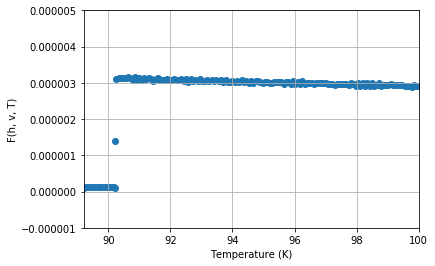

In [16]:
specific_volume = df_nitrogen['Volume (m3/kg)'].to_numpy()
spec_heat_input = df_nitrogen['Spec. Heat Input (kJ/kg)'].to_numpy()
temperature_array = df_nitrogen['Temperature (K)'].to_numpy()
C_v = df_nitrogen['Cv (J/g*K)'].to_numpy()
C_p = df_nitrogen['Cp (J/g*K)'].to_numpy()
c_ratio = C_v[0]/C_p[0]

square_root_volume = np.array([math.sqrt(specific_volume[i]) for i in range(len(specific_volume))])
Y = square_root_volume/(1000*spec_heat_input)

max_temperature_index = Y.argmax()
print('Temperature for flow capacity: {0}'.format(round(temperature_array[max_temperature_index], 3)))
critical_temperature = temperature_array[max_temperature_index]

plt.scatter(temperature_array, Y)
plt.ylim(-0.000001, 0.000005)
plt.xlim(89.2, 100)
plt.grid(axis = 'both')
plt.xlabel('Temperature (K)')
plt.ylabel('F(h, v, T)')

## Total Heat Transfer Calculation

In [17]:
def heat_transfer_cylinder(dz, T_inf, T, r_o, r_i, sigma, k, h):
    R_conduction = math.log(r_o/r_i)/(2*math.pi*k*dz)
    R_convection = 1/(h*sigma)
    R_radiation = (T_inf - T)/(epsilon*sigma*stephan_boltzmann*(math.pow(T_inf, 4) - math.pow(T, 4)))

    
    R_effective = 1/( 1/R_convection + 1/R_radiation)
    
    q = (T_inf - T)/(R_conduction + R_effective)
    
    return q

def heat_transfer_flat_plate(dt, T_inf, T, sigma, k, h):
    R_conduction = dt/(k*sigma)
    R_convection = 1/(h*sigma)
    R_radiation = (T_inf - T)/(epsilon*sigma*stephan_boltzmann*(math.pow(T_inf, 4) - math.pow(T, 4)))
    
    R_effective = 1/( 1/R_convection + 1/R_radiation)
    
    q = (T_inf - T)/(R_conduction + R_effective)
    
    return q

In [18]:
top_plate_surface_area = 0.548        # Top plate surface area (m^2)
bottom_plate_surface_area = 0.370     # Botom plate surface area (m^2)
lower_plate_surface_area = 0.178
inner_channel_surface_area = 0.084    # Top inner cylinder surface area (m^2)
outer_vessel_surface_area = 1.663     # Outer vessel surface area (m^2)
inner_vessel_surface_area = 1.023     # Inner vessel surface area (m^2)

top_plate_thickness = 0.0203          # Top plate thickness (m)
bottom_plate_thickness = 0.0203       # Bottom plate thickness (m)
lower_plate_thickness = 0.005

outer_radius_channel = 0.120          # Inner channel outer radius
inner_radius_channel = 0.118          # Outer channel outer radius
outer_vessel_radius = 0.434           # Outer vessel radius
inner_vessel_radius = 0.120           # Inner vessel radius

inner_channel_height = 0.152          # Top inner cylinder height (m)
outer_vessel_height = 0.610           # Vessell Outer Surface Height (m)
inner_vessel_height = 0.446           # Vessell Outer Surface Height (m)

thermal_conductance = 116.23          # Wall thermal conductance (W/m*K) 
thickness = 0.0049                    # Average thickness of nitrogen vessel radial walls (m)

total_surface_area = 3.866            # Total vessel surface area (m^2)

In [19]:
heat_transfer_top_plate = heat_transfer_flat_plate(top_plate_thickness, T_inf, temperature_saturation_nitrogen, 
                                                   top_plate_surface_area, thermal_conductance, h_inner_top)

heat_transfer_bottom_plate = heat_transfer_flat_plate(bottom_plate_thickness, T_inf, temperature_saturation_nitrogen, 
                                                      bottom_plate_surface_area, thermal_conductance, h_inner_bottom)

heat_transfer_lower_plate = heat_transfer_flat_plate(lower_plate_thickness, T_inf, temperature_saturation_nitrogen, 
                                                      lower_plate_surface_area, thermal_conductance, h_lower_bottom)

heat_transfer_inner_channel = heat_transfer_cylinder(inner_channel_height, T_inf, temperature_saturation_nitrogen, 
                                                     outer_radius_channel, inner_radius_channel, inner_channel_surface_area, 
                                                     thermal_conductance, h_channel)

heat_transfer_outer_vessel = heat_transfer_cylinder(outer_vessel_height, T_inf, temperature_saturation_nitrogen, 
                                                    outer_vessel_radius, outer_vessel_radius - thickness, 
                                                    outer_vessel_surface_area, thermal_conductance, h_outer)

heat_transfer_inner_vessel = heat_transfer_cylinder(inner_vessel_height, T_inf, temperature_saturation_nitrogen, 
                                                    inner_vessel_radius, inner_vessel_radius - thickness, 
                                                    inner_vessel_surface_area, thermal_conductance, h_inner)

total_heat_transfer = heat_transfer_top_plate 
total_heat_transfer+= heat_transfer_bottom_plate 
total_heat_transfer+= heat_transfer_inner_channel 
total_heat_transfer+= heat_transfer_outer_vessel 
total_heat_transfer+= heat_transfer_inner_vessel

table = [["Circular Top Plate", heat_transfer_top_plate, "NA"],
         ["Circular Bottom Plate", heat_transfer_bottom_plate, "NA"],
         ["Lower Bottom Plate", heat_transfer_lower_plate, "NA"],
         ["Inner Channel", "NA", heat_transfer_inner_channel],
         ["Outer Vessel Surface", "NA", heat_transfer_outer_vessel],
         ["Inner Vessel Surface", "NA", heat_transfer_inner_vessel]]

headers = ["Plate Name", "Heat Transfer Plate (W)", "Heat Transfer Cylinder (W)"]
print(tabulate(table, headers, tablefmt="psql"))

table = [["Total Heat Transfer", total_surface_area, total_heat_transfer]]
headers = ["", "Total Vessel Surface Area (m^2)", "Heat Transfer Cylinder (W)"]
print(tabulate(table, headers, tablefmt="psql"))

+-----------------------+---------------------------+------------------------------+
| Plate Name            | Heat Transfer Plate (W)   | Heat Transfer Cylinder (W)   |
|-----------------------+---------------------------+------------------------------|
| Circular Top Plate    | 1193.0610459194475        | NA                           |
| Circular Bottom Plate | 1508.0812675295313        | NA                           |
| Lower Bottom Plate    | 899.1486619129772         | NA                           |
| Inner Channel         | NA                        | 204.24269172229876           |
| Outer Vessel Surface  | NA                        | 2932.3626634910906           |
| Inner Vessel Surface  | NA                        | 1904.6655380083366           |
+-----------------------+---------------------------+------------------------------+
+---------------------+-----------------------------------+------------------------------+
|                     |   Total Vessel Surface Area (m^2) |

## Nitrogen vessel geometry constants (m)

In [20]:
inner_top_plate_radius = 0.44
inner_bottom_plate_radius = 0.37
top_plate_thickness = 0.023
outer_wall_thickness =  0.0051
inner_wall_thickness =  0.0051
inner_length = 0.48
outer_length = 0.61
inner_channel_length = 0.15
inner_channel_radius = 0.12
inner_channel_thickness = 0.003
nitrogen_port_inner_diameter = 0.01  # 0.375" ID
nitrogen_port_outer_diameter = 0.013  # 0.52" OD
nitrogen_port_length = 0.197

## Flow Characteristics

In [21]:
def calculate_effective_discharge_area(m_flow, gas_ratio, mass, in_pressure, in_temperature, compressability, C):
    k_b = 1.0          
    k_c = 1.0        # No rupture disk
    k_d = 0.975      # PRV with/without rupture disk
    
    A = ((m_flow)/(C*k_b*k_c*k_d*in_pressure))*math.sqrt(in_temperature*compressability/mass)
    
    return A
    

In [22]:
P_critical = pressure_relieving*math.pow(2/(c_ratio + 1), c_ratio/(c_ratio - 1))
print('Ratio of C_p/C_v: {0}'.format(round(c_ratio, 3)))
print('Critical flow pressure: {0}'.format(round(pascal_to_psi(P_critical), 3)))  # Critical flow it is

Ratio of C_p/C_v: 0.499
Critical flow pressure: 39.915


## Mass Flow

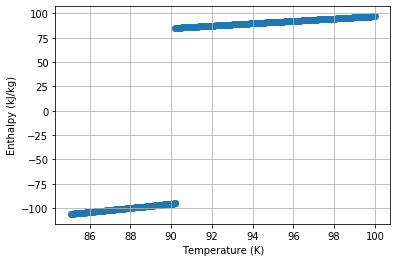

,Temperature (K),Enthalpy (kJ/kg),Phase
67,90.025,-95.461,liquid
68,90.100,-95.300,liquid
69,90.175,-95.139,liquid
70,90.204,-95.077,liquid
71,90.204,85.062,vapor
72,90.250,85.120,vapor
73,90.325,85.215,vapor
74,90.400,85.310,vapor
75,90.475,85.405,vapor
76,90.550,85.500,vapor


In [23]:
enthalpy = df_nitrogen['Enthalpy (kJ/kg)'].to_numpy()
temperature_array = df_nitrogen['Temperature (K)'].to_numpy()

plt.scatter(temperature_array, enthalpy)
plt.grid(axis = 'both')
plt.xlabel('Temperature (K)')
plt.ylabel('Enthalpy (kJ/kg)')
plt.show()

df_nitrogen[df_nitrogen['Temperature (K)'] > 90][['Temperature (K)', 'Enthalpy (kJ/kg)', 'Phase']].head(20)

In [24]:
latent_heat = (85.062 - (-95.077))*1000   # J/kg  The change in enthalpy between the liquid and vapor states
print('Latent heat of vaporization: {} J/kg'.format(round(latent_heat, 3)))

W = (total_heat_transfer*3600)/latent_heat

print('Mass flow: {} kg/hr'.format(round(W, 3)))

Latent heat of vaporization: 180139.0 J/kg
Mass flow: 154.729 kg/hr


In [25]:
R = 8.314    # Gas Constant  kg⋅m2·K−1⋅mol−1s−2
df_nitrogen[df_nitrogen['Temperature (K)'] > critical_temperature][['Temperature (K)', 'Density (kg/m3)']].head()

,Temperature (K),Density (kg/m3)
78,90.700,15.215
79,90.775,15.197
80,90.850,15.180
81,90.925,15.162
82,91.000,15.145


In [26]:
nitrogen_density = df_nitrogen[df_nitrogen['Temperature (K)'] > critical_temperature]['Density (kg/m3)'].iloc[0]
Z = (pressure_relieving*nitrogen_mass)/(nitrogen_density*R*spec_heat_input[max_temperature_index]*1000)
print('Nitrogen density at inlet: {} kg/m^3'.format(nitrogen_density))
print('Compressability at inlet: {}'.format(Z))

Nitrogen density at inlet: 15.215 kg/m^3
Compressability at inlet: 1.0003873603986762


In [27]:
C = 0.0283                  # Look-up table 8 in API-520 manual
mass_flow = (3600*total_heat_transfer)/(latent_heat)
print('Mass flow: {} kg/hr'.format(round(mass_flow, 3)))
p1 = pressure_relieving/1000

A = round(calculate_effective_discharge_area(mass_flow, 
                                         c_ratio, 
                                         nitrogen_mass, 
                                         p1, 
                                         temperature_array[max_temperature_index], 
                                         Z, 
                                         C), 6)

D = 2*math.sqrt(A/math.pi)
print('Nozzle Area: {} mm^2'.format(round(A, 3)))
print('Nozzle diameter: {0} mm'.format(round(D, 3)))

Mass flow: 154.729 kg/hr
Nozzle Area: 27.502 mm^2
Nozzle diameter: 5.918 mm


## Critical flow & Backpressure

Per 5.3.1.1 - 5.6.2.5 of API-520 the backpressure, here $P_{atm}$ + 10\% x $P_{set}$ = 20.7 psi, must be $\leq$ $P_{cf}$, ie.

$P_{cf} \leq (P_{atm} + 0.1P_{set})$                                    

In [28]:
critical_flow_coefficient = math.pow(2/(c_ratio + 1), c_ratio/(c_ratio - 1))
print('Critial flow condition coefficient: {}'.format(round(critical_flow_coefficient, 2)))

Critial flow condition coefficient: 0.75


In [29]:
critical_pressure = pressure_relieving*critical_flow_coefficient
print("Critical pressure: {} psi".format(round(pascal_to_psi(critical_pressure), 3)))
print('Relieving pressure: {} psi'.format(round(pascal_to_psi(pressure_relieving),3)))

Critical pressure: 39.915 psi
Relieving pressure: 53.2 psi


 According to the critical flow condition, the flow is critical when $\frac{P_{cf}}{P_{r}} = \left(\frac{2}{k+1}\right)^{\frac{k}{k-1}}$. This gives $P_{cf} = 0.75P_{r}$. Therefore, if the pressure downstream of the nozzle is $\leq$ to the critical pressure($P_{cf}$), choked flow will occur. In our case, choked flow is apparent.

## Friction Factor

In [30]:
dynamic_viscosity = df_nitrogen[df_nitrogen['Temperature (K)'] > temperature_saturation_nitrogen]['Viscosity (Pa*s)'].iloc[0]

Re = 4*mass_flow/(3600*math.pi*dynamic_viscosity*nitrogen_port_inner_diameter)
print("Reynolds number: {Re}".format(Re=round(Re, 3)))

f = 0.25/math.pow(math.log10(((0.0015/2.78)/3.7) + (5.74/(math.pow(Re, 0.8)))), 2)
print("Friction factor: {f}".format(f=round(f, 3)))

df_nitrogen[df_nitrogen['Temperature (K)'] > temperature_saturation_nitrogen]

Reynolds number: 840771.128
Friction factor: 0.019


,Temperature (K),Pressure (psia),Density (kg/m3),Volume (m3/kg),Internal Energy (kJ/kg),Enthalpy (kJ/kg),Entropy (J/g*K),Cv (J/g*K),Cp (J/g*K),Sound Spd. (m/s),Joule-Thomson (F/psia),Viscosity (Pa*s),Therm. Cond. (W/m*K),Phase,Spec. Heat Input (kJ/kg)
78,90.700,53.2,15.215,0.065727,61.581,85.689,5.1561,0.80656,1.2625,182.58,0.25421,0.000007,0.009075,vapor,82.158750
79,90.775,53.2,15.197,0.065802,61.647,85.784,5.1571,0.80625,1.2616,182.69,0.25372,0.000007,0.009079,vapor,83.349200
80,90.850,53.2,15.180,0.065878,61.714,85.878,5.1581,0.80595,1.2606,182.81,0.25324,0.000007,0.009083,vapor,81.480684
81,90.925,53.2,15.162,0.065953,61.781,85.973,5.1592,0.80566,1.2597,182.92,0.25276,0.000007,0.009087,vapor,83.540467
82,91.000,53.2,15.145,0.066029,61.848,86.067,5.1602,0.80536,1.2588,183.03,0.25229,0.000007,0.009091,vapor,81.667447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,99.700,53.2,13.424,0.074492,69.333,96.657,5.2714,0.78168,1.1842,194.89,0.20697,0.000007,0.009799,vapor,93.377296
199,99.775,53.2,13.412,0.074562,69.396,96.746,5.2723,0.78153,1.1837,194.99,0.20665,0.000007,0.009806,vapor,94.800257
200,99.850,53.2,13.399,0.074633,69.459,96.834,5.2732,0.78139,1.1833,195.09,0.20633,0.000007,0.009814,vapor,92.502873
201,99.925,53.2,13.386,0.074704,69.521,96.923,5.2741,0.78125,1.1828,195.18,0.20601,0.000007,0.009821,vapor,93.643042


## Flow Capacity

In [31]:
Q_a = W/nitrogen_density   # gas density
print('Flow capacity: {} m^3/hr'.format(round(Q_a, 3)))

Flow capacity: 10.169 m^3/hr


## Friction Factor

![title](cross_section_piping.png)

In [32]:
## K-Factor Calculations

def k_factor_circular_pipe(f, L, D):
    return f*(L/D)

def k_factor_90deg_bend(r, d, f):
    ratio = int(r/d)
    k_dict = {"1": 20,
             "2": 12,
             "3": 12,
             "4": 14,
             "6": 17,
             "8": 24,
             "10": 30}
    k = k_dict[str(ratio)]
    
    return f*k

def k_factor_manifold_main(Q_b, Q_c):
    return (1.55*(Q_b/Q_c) - math.pow(Q_b/Q_c, 2))

def k_factor_enlargement(D_i, D_o):
    k = math.pow(1 - math.pow(D_i, 2)/math.pow(D_o, 2),2)
    return k

def k_factor_manifold_input(Q_b, Q_c, D_branch, D_comb):
    C = 1.0
    D = 1.0
    E = 2.0
    beta = D_branch/D_comb
    
    K = C*( 1 +  D*math.pow(Q_b/(Q_c*math.pow(beta, 2)), 2) - E*math.pow(1 - (Q_b/Q_c), 2))
    return K

def k_factor_mitre(f):
    return 60*f

#### Flow Path A-B-C

long_diameter = 0.022    # long relief pipe ID, path A-B-C
long_length = 0.933      # long relief pipe length, path A-B-C

K_vessel_relief = k_factor_circular_pipe(f, 
                                         nitrogen_port_length, 
                                         nitrogen_port_inner_diameter)

K_vessel_relief *= math.pow(long_diameter/nitrogen_port_inner_diameter, 4) # 0.375" -> 0.870" pipe

K_relief_entrance = 0.5                                  # Crane's Flow of Fluids A-30, sharp edged pipe entrance   
K_port_enlargement = k_factor_enlargement(nitrogen_port_inner_diameter, 
                                        long_diameter)   # Crane's Flow of Fluids A-30, inward projected pipe entrance

K_right_bend = k_factor_90deg_bend(0.025, long_diameter, f)   
K_long = k_factor_circular_pipe(f, long_length, long_diameter)

K_path_a = K_vessel_relief
K_path_a+= K_relief_entrance
K_path_a+= K_port_enlargement
K_path_a+= K_right_bend
K_path_a+= K_long

#### Flow Path: D-E

short_diameter = 0.022   # short relief pipe ID, path D-E
short_length = 0.548     # short relief pipe length, path D-E

K_short = k_factor_circular_pipe(f, short_length, short_diameter)

K_path_b = K_vessel_relief
K_path_b+= K_short
K_path_b+= K_relief_entrance
K_path_b+= K_port_enlargement


#### Manifold

manifold_diameter = 0.034925                            # Manifold body diameter
manifold_length_path_a_b = 0.076                        # Manifold path between A-B-C & D-E length
manifold_length_path_b = 0.196                          # Manifold path B length

K_manifold_mitre = k_factor_mitre(f)                    # Entrance from path A, modeled as a mitre bend

length_right_bend = 0.085                               # Arc length of right angle bend on path A-B-C
relief_inner_diameter = long_diameter
relief_outer_diameter = 0.025

length_vessel_to_prv = nitrogen_port_length 
+ length_right_bend 
+ long_length
+ manifold_length_path_a_b 
+ manifold_length_path_b 


# ====================================================
#
# From the Darcy-Weisbach equation:
#
# Q = (Q_a) + (Q_b)
#
# (Q_a)^2/(Q_b)^2 = (L_2/L_1)
#
#  ==> Q_a = sqrt(L_2/L_1)(Q_b)^2
#
#  ==> Q_1 = Q/(1 + sqrt(L_1/L_2))
#
#  ==> Q_2 = Q/(1 + sqrt(L_2/L_1))
#
# =====================================================

length_a = nitrogen_port_length + length_right_bend + long_length + manifold_length_path_a_b
length_b = nitrogen_port_length + short_length



Q_c = Q_a/( 1 + math.sqrt(length_b/length_a))          # Branch flow - total flow distributed over each pipe
Q_b = Q_a/( 1 + math.sqrt(length_a/length_b))          # Combination flow - total flow distributed over each pipe

K_manifold_flow = k_factor_manifold_main(Q_b, Q_c)   

K_manifold_input = k_factor_manifold_input(Q_b,        # Entrance from path B, modeled as a hydraulic tee
                                           Q_c,
                                           long_diameter,
                                           manifold_diameter)     

K_manifold_body_path_a = k_factor_circular_pipe(f,     # The circular pipe flow through the manifold to the PRV
                                             manifold_length_path_a_b, 
                                             manifold_diameter) 

K_manifold_body_path_b = k_factor_circular_pipe(f,     # The circular pipe flow through the manifold to the PRV
                                             manifold_length_path_b, 
                                             manifold_diameter) 

K_manifold_body_path_a *= math.pow(long_diameter/manifold_diameter, 4) # scaling conversion from small to large
K_manifold_body_path_b *= math.pow(long_diameter/manifold_diameter, 4) # scaling conversion from small to large

K_path_a = 4*K_path_a + K_manifold_mitre
K_path_a+= K_manifold_body_path_a            # Path including bend up to the port for path B; recombination point

K_total_parallel_lines = 1/((1/K_path_a) + 1/(K_path_b)) # K-factors add in parallel


K_total_parallel_lines += K_manifold_flow    # Added resistance due to combination, K_run in Crane's Manual
K_total_parallel_lines += K_manifold_input   # Factor due to branch impur flow, K_branch in Crane's Manual


K_factor_total_path = K_total_parallel_lines + K_manifold_body_path_b

print('Total K-factor: {}'.format(round(K_factor_total_path, 3)))

equiv_length = (K_factor_total_path*long_diameter)/f

print('Eq length: {}'.format(round(equiv_length, 3)))


Total K-factor: 13.721
Eq length: 15.661


## Pressure Drop
$\Delta P = f \frac{\nu l W^{2}}{d^{5}}$

In [33]:
specific_volume = df_nitrogen[df_nitrogen['Temperature (K)'] > critical_temperature]['Volume (m3/kg)'].iloc[0]

pressure_drop = (f*equiv_length*math.pow(W/3600, 2)*specific_volume)/math.pow(long_diameter, 5)
print('Head loss due to relief line: {} psi'.format(round(pascal_to_psi(pressure_drop), 3)))

precent_over_mawp = 100*(pressure_drop + pressure_saturation_abs)/(pressure_saturation_abs)
print('Percent over pressure (must be < 110%): {}%'.format(round(precent_over_mawp), 3))

Head loss due to relief line: 1.031 psi
Percent over pressure (must be < 110%): 102.0%


## Condition for set pressure

In [34]:
minimum_pressure_drop = 0.03*pressure_set
print('Minimum desired pressure drop: {}'.format(round(pascal_to_psi(minimum_pressure_drop), 3)))

Minimum desired pressure drop: 1.05
